In [1]:
import os

import scutils_cnb_clean
from scutils_cnb_clean import *
np.random.seed(234902)

from mpl_toolkits.mplot3d.art3d import LineCollection
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import NearestNeighbors

import rpy2
import anndata2ri

import scanpy
import anndata

import gseapy

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
%matplotlib inline

In [3]:
working_dir = '/Users/burdziac/Documents/PDAC/notebooks_final_June2021/'

# Functions

In [4]:
def plot_G(tsne, G,ax,
           alpha_G=0.7, color_G='r',s=10,t='k',cmap='viridis',colorbar=False, 
           colorbar_pos = [.85, .65, 0.07, 0.21]):
    
    # generate collection of all edges (assumes symmetric)
    segments = [tsne[[i, j],:] for (i, j) in G.todok().keys() if i < j]
    ax.add_collection(LineCollection(segments, colors=color_G, alpha=alpha_G))

    plt.axis("off")
    scatterplt = ax.scatter(tsne[:,0],tsne[:,1],s=s,c=t,cmap=cmap,edgecolor='k',zorder=10,vmin=-5,vmax=5)
    
    if colorbar:
        cax = fig.add_axes(colorbar_pos)
        cbar = fig.colorbar(scatterplt, cax)
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(25)
    return ax

#using script from Joe Chan
def convert_genes(genes_to_map,direction='h2m'):
    pd.DataFrame(genes_to_map,columns=['Genes']).to_csv("scripts/script_intermediates/genes_tmp.csv")
    command = "Rscript scripts/ConvertHuman2MouseGenes_Joe_CNBEdit.R {}".format(direction)
    os.system(command)
    output = pd.read_csv("scripts/script_intermediates/converted_tmp.csv",index_col=0)
    os.system("rm scripts/script_intermediates/converted_tmp.csv")
    return output['x'].values

def plot_G2(tsne, G,ax,
           alpha_G=0.7, color_G='r',s=10,t='k',cmap='viridis',colorbar=False):
    
    # generate collection of all edges (assumes symmetric)
    segments = [tsne[[i, j],:] for (i, j) in G.todok().keys() if i < j]
    ax.add_collection(LineCollection(segments, colors=color_G, alpha=alpha_G))

    if colorbar:
        plt.colorbar()
    plt.axis("off")
    ax.scatter(tsne[:,0],tsne[:,1],s=s,c=t,cmap=cmap,edgecolor='k',zorder=10)
    return ax

# Hard-coded Metadata

In [5]:
stage_dict = {'DACD346_Kate_plus': 'T4/IL33KD',
 'DACD350_Kate_plus': 'T4',
 'DACD351_Kate_plus': 'T3',
 'DACD347_KATE_PLUS': 'T5/IL33KD',
 'DACD345_KATE_PLUS_GFP': 'T5/IL33KD',
 'DACD349_KATE_PLUS': 'T5',
 'DACE621-mKate2_pos': 'T4',
 'DACE604-mKate2_pos': 'T4/IL33KD',
 'DACE605-mKate2_pos': 'T4/IL33KD',
 'E607-EPI': 'T5/IL33KD',
 'E610-EPI': 'T5',
 'E614-EPI': 'T5/IL33KD'}

In [6]:
cohort_dict = {'DACD346_Kate_plus': 'C1',
 'DACD350_Kate_plus': 'C1',
 'DACD351_Kate_plus': 'C1',
 'DACD347_KATE_PLUS': 'C1',
 'DACD345_KATE_PLUS_GFP': 'C1',
 'DACD349_KATE_PLUS': 'C1',
 'DACE621-mKate2_pos': "C2",
 'DACE604-mKate2_pos': 'C2',
 'DACE605-mKate2_pos': 'C2',
 'E607-EPI': 'C2',
 'E610-EPI': 'C2',
 'E614-EPI': 'C2'}

In [7]:
color_dict= {
"T3":"#EED04D",
"T4":"#1D89E3",
"T5":"#F8BADE",
"T4/IL33KD":"#004b8a",
"T5/IL33KD":"#804e6b"}

In [8]:
#cell type mapping from phenograph clusters to import
acinar = [7,13]
progenitor = [5,4,0,1,11]
mucinous = [3,2,6,10]
tuft = [14]
NE = [8,9,15,16,12]

celltype_dict = dict(acinar=acinar,progenitor=progenitor,tuft=tuft,mucinous=mucinous,NE=NE)

In [9]:
#Modules Interaction Status with IL33
#second version with IL33 co-receptor required

status_dict = {4:"noninteracting",6:"interacting",
               0:"interacting",1:"noninteracting",
               2:"interacting",3:"interacting",5:"interacting"}

# Set up R Environment

In [10]:
anndata2ri.activate()

In [11]:
%load_ext rpy2.ipython

In [12]:
%%R
library(miloR)
library(igraph)
library(ggplot2)

R[write to console]: Loading required package: edgeR

R[write to console]: Loading required package: limma

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following object is masked from ‘package:miloR’:

    graph


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union




# Preparation to Run Milo

## Load Data in Python 

In [13]:
sc = load_sc(working_dir+"saved_analyses/T5_All_NoMes.pickle")
a = pd.read_csv(working_dir+"misc_files/shIL33_T5_MILO_clusters.csv",index_col=None,header=None).values.T[0]

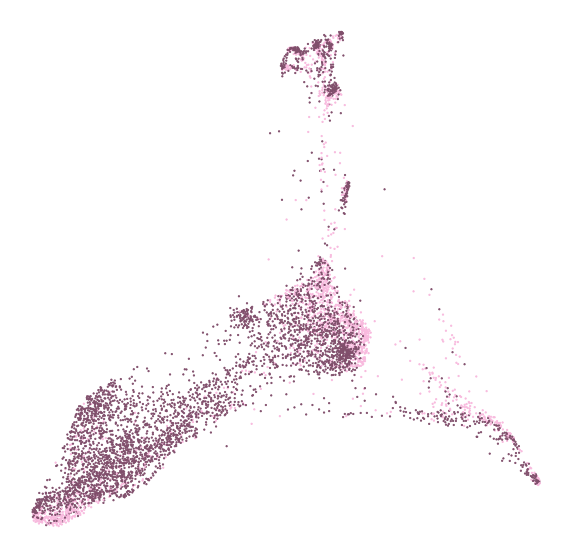

In [14]:
fig,ax=plt.subplots(figsize=(10,10))
colors = [color_dict[stage_dict[sample]] for sample in sc.sample_ids]
ax.scatter(sc.layout_log.values[:,0],sc.layout_log.values[:,1],c=colors,s=2)
ax.set_axis_off()

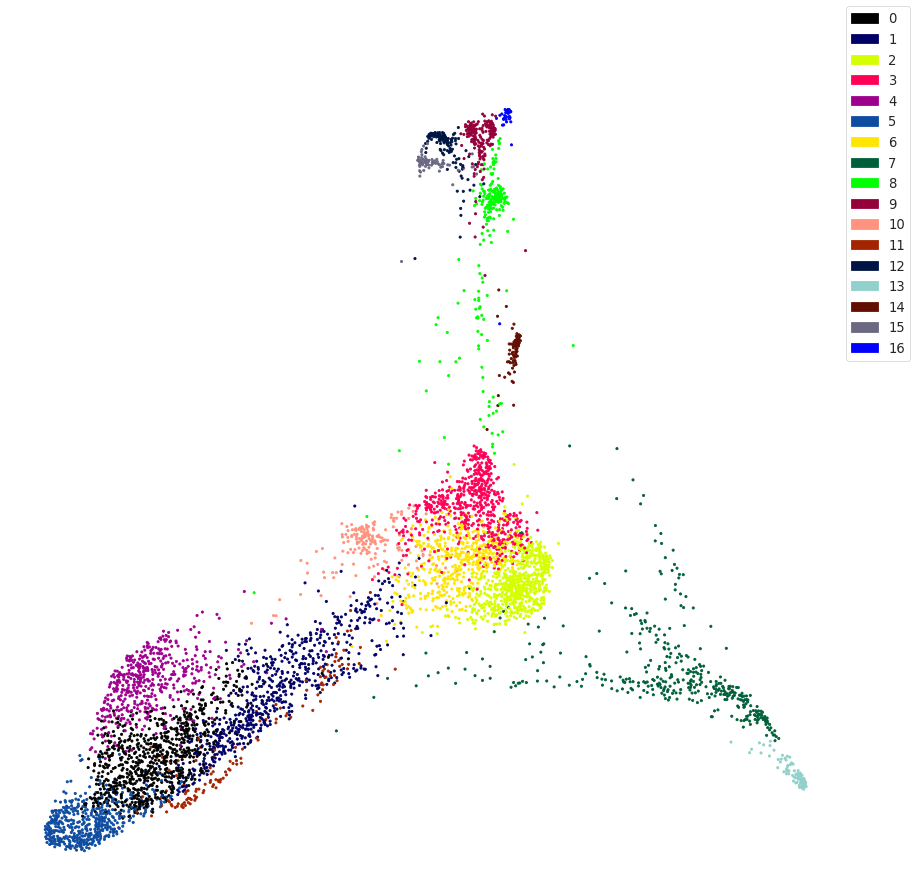

In [15]:
categorical_plot(sc.layout_log,a)

In [16]:
celltypes = np.array(["undefined_celltype"]*len(a))
for key in celltype_dict.keys():
    clusts = celltype_dict[key]
    clust_ix = np.where(np.array([cell in clusts for cell in a]))
    celltypes[clust_ix] = key

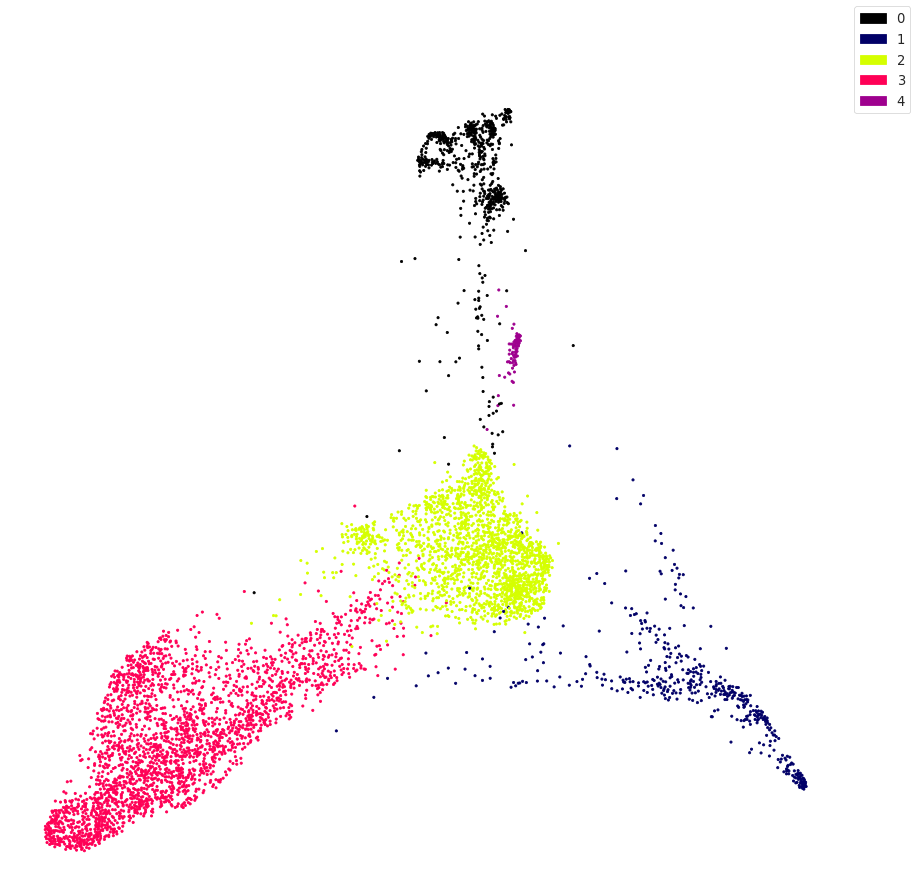

In [17]:
categorical_plot(sc.layout_log,LabelEncoder().fit_transform(celltypes))

## Set Up adata Object & Pass to R

In [18]:
cell_barcodes = ["{}_{}".format(sc.cell_ids[i],sc.sample_ids[i]) for i in range(sc.data.shape[0])]
condition = [stage_dict[i] for i in sc.sample_ids]
cohort = [cohort_dict[i] for i in sc.sample_ids]

obs = pd.DataFrame(dict(batch=sc.sample_ids,total_molecules=sc.lib_size.astype(np.int32),
                       condition=condition,cohort=cohort,celltype=celltypes,cluster=a),
                   index=cell_barcodes)

var = pd.DataFrame(index=sc.genes_all)

obsm = {"X_pca":sc.pc_log,
       "X_tsne":sc.layout_log.values,"X_umap":sc.layout_log.values}

num_PCs = sc.npca_log

In [19]:
adata = anndata.AnnData(X=np.log2(sc.data_all.toarray()+.1),
                        obs=obs, 
                        var=var, 
                        uns=None, 
                        obsm=obsm, 
                        varm=None, layers=None, raw=None, dtype='float32', 
                        shape=None, filename=None, filemode=None, asview=False, 
                        obsp=None, varp=None, oidx=None, vidx=None)

In [20]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 15845 5300 
metadata(0):
assays(1): X
rownames(15845): 0610007P14RIK 0610009B22RIK ... ZZEF1 ZZZ3
rowData names(0):
colnames(5300): 120703423761765_DACD349_KATE_PLUS
  120703436843316_DACD349_KATE_PLUS ... 241114562582772_E614-EPI
  241114608515811_E614-EPI
colData names(6): batch total_molecules ... celltype cluster
reducedDimNames(3): PCA TSNE UMAP
mainExpName: NULL
altExpNames(0):


In [21]:
%%R 
milo <- Milo(adata)
milo

class: Milo 
dim: 15845 5300 
metadata(0):
assays(1): X
rownames(15845): 0610007P14RIK 0610009B22RIK ... ZZEF1 ZZZ3
rowData names(0):
colnames(5300): 120703423761765_DACD349_KATE_PLUS
  120703436843316_DACD349_KATE_PLUS ... 241114562582772_E614-EPI
  241114608515811_E614-EPI
colData names(6): batch total_molecules ... celltype cluster
reducedDimNames(3): PCA TSNE UMAP
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1


In [22]:
%%R -i num_PCs
num_PCs

[1] 51


In [23]:
%%R 
milo <- buildGraph(milo, k=20, d=num_PCs,
  transposed = TRUE,
  get.distance = FALSE,
  reduced.dim = "PCA"
)

R[write to console]: Constructing kNN graph with k:20



In [24]:
%%R
milo

class: Milo 
dim: 15845 5300 
metadata(0):
assays(1): X
rownames(15845): 0610007P14RIK 0610009B22RIK ... ZZEF1 ZZZ3
rowData names(0):
colnames(5300): 120703423761765_DACD349_KATE_PLUS
  120703436843316_DACD349_KATE_PLUS ... 241114562582772_E614-EPI
  241114608515811_E614-EPI
colData names(6): batch total_molecules ... celltype cluster
reducedDimNames(3): PCA TSNE UMAP
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(1): graph
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1


# Run Milo

## Prepare Design Matrix for Milo

In [25]:
#define dataframe to input in milo (at least cells x independent variable)
design_df = obs[["batch", "condition",'cohort']]
design_df.drop_duplicates(inplace=True)
design_df.index = design_df['batch']
design_df

/Users/burdziac/Documents/bin/miniconda2/envs/MyEnv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,batch,condition,cohort
batch,,,
DACD349_KATE_PLUS,DACD349_KATE_PLUS,T5,C1
DACD347_KATE_PLUS,DACD347_KATE_PLUS,T5/IL33KD,C1
E610-EPI,E610-EPI,T5,C2
E607-EPI,E607-EPI,T5/IL33KD,C2
E614-EPI,E614-EPI,T5/IL33KD,C2


## Run Milo in R

In [26]:
%%R -i design_df -o DA_results
## Define neighbourhoods
milo <- makeNhoods(milo, prop = 0.1, k = 20, d=num_PCs, refined = TRUE)

## Count cells in neighbourhoods
milo <- countCells(milo, meta.data = data.frame(colData(milo)), sample="batch")

## Calculate distances between cells in neighbourhoods
## for spatial FDR correction
milo <- calcNhoodDistance(milo, d=num_PCs)

## Test for differential abundance set ~ <confounding_variable>  + <independent variable>

#correcting for confounding variable (key of that variable in original adata.obs)
#DA_results <- testNhoods(milo, design = ~ confounding_variable + independent_variable , design.df = design_df)

#without correcting for confounding variable
DA_results <- testNhoods(milo, design = ~ cohort + condition , design.df = design_df)

R[write to console]: Checking valid object

R[write to console]: Checking meta.data validity

R[write to console]: Counting cells in neighbourhoods

R[write to console]: Using TMM normalisation

R[write to console]: Performing spatial FDR correction withk-distance weighting



In [27]:
%%R
milo

class: Milo 
dim: 15845 5300 
metadata(0):
assays(1): X
rownames(15845): 0610007P14RIK 0610009B22RIK ... ZZEF1 ZZZ3
rowData names(0):
colnames(5300): 120703423761765_DACD349_KATE_PLUS
  120703436843316_DACD349_KATE_PLUS ... 241114562582772_E614-EPI
  241114608515811_E614-EPI
colData names(6): batch total_molecules ... celltype cluster
reducedDimNames(3): PCA TSNE UMAP
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 5300 393
nhoodCounts dimensions(2): 393 5
nhoodDistances dimension(1): 393
graph names(1): graph
nhoodIndex names(1): 393
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1


In [28]:
DA_results.sort_values('FDR')

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
50,-4.368037,12.358845,2.125002e+01,0.000005,0.001848,50.0,0.001761
384,-3.768614,12.885136,1.786726e+01,0.000026,0.004136,384.0,0.003970
206,-4.023168,12.199343,1.721913e+01,0.000037,0.004136,206.0,0.003970
296,-4.928608,11.939421,1.696559e+01,0.000042,0.004136,296.0,0.003970
40,-3.478059,12.454899,1.577404e+01,0.000078,0.005104,40.0,0.004960
...,...,...,...,...,...,...,...
162,-0.051638,11.546012,2.425103e-03,0.960736,0.969484,162.0,0.969399
186,-0.041631,11.896723,2.238035e-03,0.962280,0.969484,186.0,0.969399
360,-0.035827,12.304673,1.976526e-03,0.964551,0.969484,360.0,0.969399
230,0.055681,11.082722,1.129571e-03,0.973197,0.975680,230.0,0.975617


In [29]:
%%R -o DA_results_annot
DA_results_annot <- annotateNhoods(milo, DA_results, coldata_col = "celltype")

R[write to console]: Converting celltype to factor...



In [30]:
DA_results_annot = DA_results_annot.set_index("celltype")

## Visualize Milo Results

### In R

In [31]:
%%R -w 1000 -h 800
milo <- buildNhoodGraph(milo)

### In Python

In [32]:
%%R -o nhood_graph -o nhood_graph_indices -o nh_size
## Save the adjacency matrix of the nhood graph
nhood_graph = as_adjacency_matrix(nhoodGraph(milo), attr="weight")

##save the indices of the adjacency matrix
nhood_graph_indices = names(nhoodDistances(milo))

## get sizes of neighborhoods
nh_size=colSums(nhoods(milo))

In [33]:
%%R -o nh_tsne_df
## Save the positions in tsne of nhood indices
nh_tsne_df = reducedDim(milo, "TSNE")[unlist(nhoodIndex(milo)),]

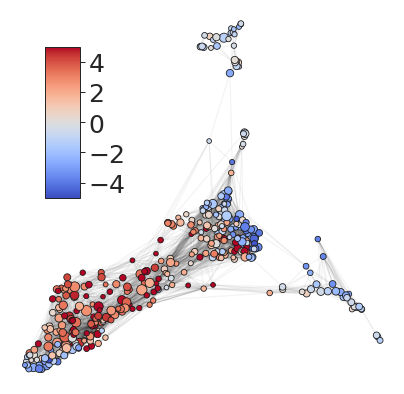

In [34]:
fig,ax=plt.subplots(figsize=(7,7))
plot_G(nh_tsne_df,
           nhood_graph,
           alpha_G=0.05,ax=ax,
           color_G='k',
           s=nh_size*1,
           t=DA_results.logFC,
           cmap='coolwarm',colorbar=True,
          colorbar_pos=[.2, .5, 0.07, 0.3])

plt.savefig(working_dir+"final_figures/Figure6/shIL33MILO-FDL_logFC_small.png",bbox_inches='tight')

# Visualize Results with Pseudotime

## Get Neighborhood Expression from Milo

In [35]:
%%R -o nhood_exp

milo = calcNhoodExpression(milo, assay = "X")
nhood_exp = nhoodExpression(milo)

In [36]:
nhood_exp = pd.DataFrame(nhood_exp.T,columns=var.index)
nhood_exp_z = ((nhood_exp.T-nhood_exp.mean(1))/nhood_exp.std(1)).T
nhood_exp_z_heatmap = (nhood_exp-nhood_exp.mean(0))/nhood_exp.std(0)

In [37]:
pca_projections, _ = palantir.utils.run_pca(nhood_exp, use_hvg=False)

In [38]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=10)

Determing nearest neighbor graph...


In [39]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

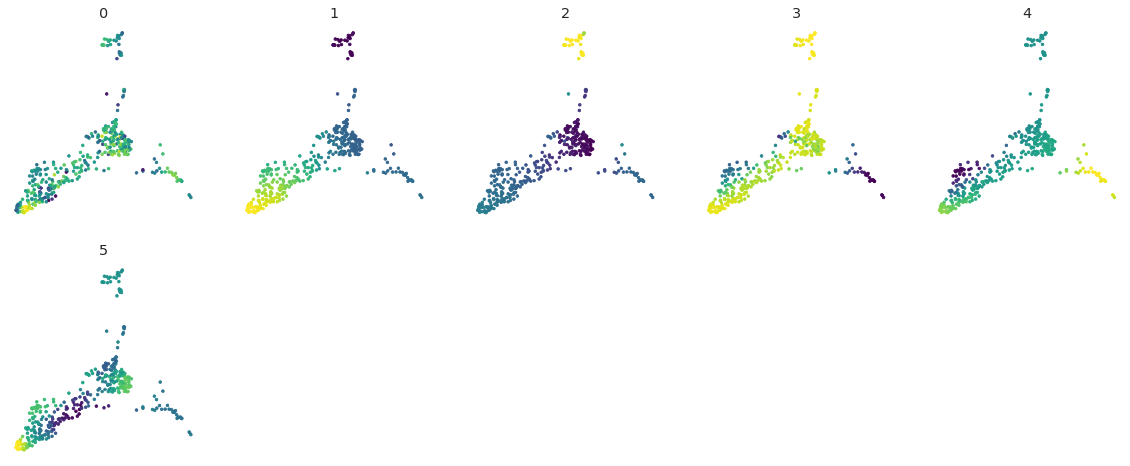

In [40]:
gene_plot(nh_tsne_df,np.exp(dm_res['EigenVectors']),range(6),cmap='viridis')

In [41]:
#modify below based on the orientation of DCs
start_cell = str(np.argmax(dm_res['EigenVectors'][1]))
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0006744464238484701 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.13400818506876627 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


<AxesSubplot:>

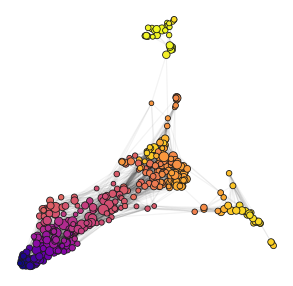

In [42]:
fig,ax=plt.subplots(figsize=(5,5))
plot_G2(nh_tsne_df,
           nhood_graph,
           alpha_G=0.05,ax=ax,
           color_G='k',
           s=nh_size*1,cmap='plasma',
           t=pr_res.pseudotime,colorbar=False)

In [43]:
nhood_order = np.argsort(pr_res.pseudotime)

In [44]:
regressionLineOrder = 6
regressionLine = np.polyfit(np.arange(len(nhood_order)),DA_results.logFC.values[nhood_order], regressionLineOrder)
p = np.poly1d(regressionLine)

In [45]:
celltype_colors = {'mucinous':sc.palette[0],'progenitor':sc.palette[1],
                  'NE':sc.palette[9],
                  'acinar':sc.palette[3],
                  'tuft':sc.palette[13],
                  'progenitor':sc.palette[1]}

In [46]:
%%R -o nhood_dge
nhood_dge <- findNhoodMarkers(milo, DA_results, overlap=1, compute.new=TRUE,assay='X')

R[write to console]: Found 161 DA neighbourhoods at FDR 10%

R[write to console]: Computing nhood adjacency

R[write to console]: Nhoods aggregated into 8 groups



In [47]:
for i in np.arange(1,7):
    print(i, nhood_dge.sort_values("logFC_{}".format(str(i)))[:100].index)

1 Index(['CPE', 'TUBA1A', 'CTLA2A', 'FN1', 'CDKN2A', 'IGFBP4', 'FXYD5', 'HMGA2',
       'PTP4A3', 'MAP1B', 'CLDN6', 'PKM', 'F2R', 'MAST4', 'CAPG', 'SLC4A11',
       'TNFRSF23', 'NT5E', 'CSF2', 'RAMP1', 'LGALS1', 'AA467197', 'TGFB1',
       'ATG9B', 'GALNT1', 'CRLF1', 'AKR1C13', 'TRBC1', 'PROCR', 'SERPINE2',
       'ANTXR2', 'KRT20', 'LAMA3', 'AK1', 'CDKN1C', 'COL18A1', 'CRIP2',
       '2310007B03RIK', 'NGF', 'SDC1', 'FAM3C', 'BEX2', 'LAMC2', 'GSN',
       'ACSBG1', 'ITGB4', 'CHST2', 'LBH', 'NBL1', 'ALDH1A3', 'PSRC1', 'TSPAN1',
       'CHGB', 'RESP18', 'APLP1', 'AREG', 'GDPD5', 'DYRK3', 'LAMB1', 'REEP5',
       'PCSK1N', 'CALM1', 'AGA', 'MSN', 'AKR1C12', 'RGS12', 'TNNT2', 'KRAS',
       'TRY5', 'MCPT8', 'ENHO', 'LEPROTL1', 'FBLN2', 'GATM', 'TRBC2', 'CHGA',
       'TRP53I11', 'RDH10', 'SCG5', 'TMSB4X', 'BMP2', 'PHLDA3', 'ANXA8',
       'DDIT4', 'TPM1', 'UCHL1', 'PDGFA', 'CDKN1A', 'ENPP1', 'TRY10', 'ANXA10',
       'PTPRN', 'ACOT7', 'SMIM14', 'PKP1', 'YWHAG', 'ETV4', 'RHOC', 'UQCC2',
    

# Integrating Plasticity Signature

In [49]:
entropy_corrs = pd.read_csv(working_dir+"final_outputs/Figure3/Plasticity_Correlations.csv",index_col=0)

In [50]:
plastic_genes = (entropy_corrs['correlation'].values>0)*(entropy_corrs['p-value'].values<(0.01/entropy_corrs.shape[0]))

In [51]:
geneset = np.array(entropy_corrs.iloc[plastic_genes].index)

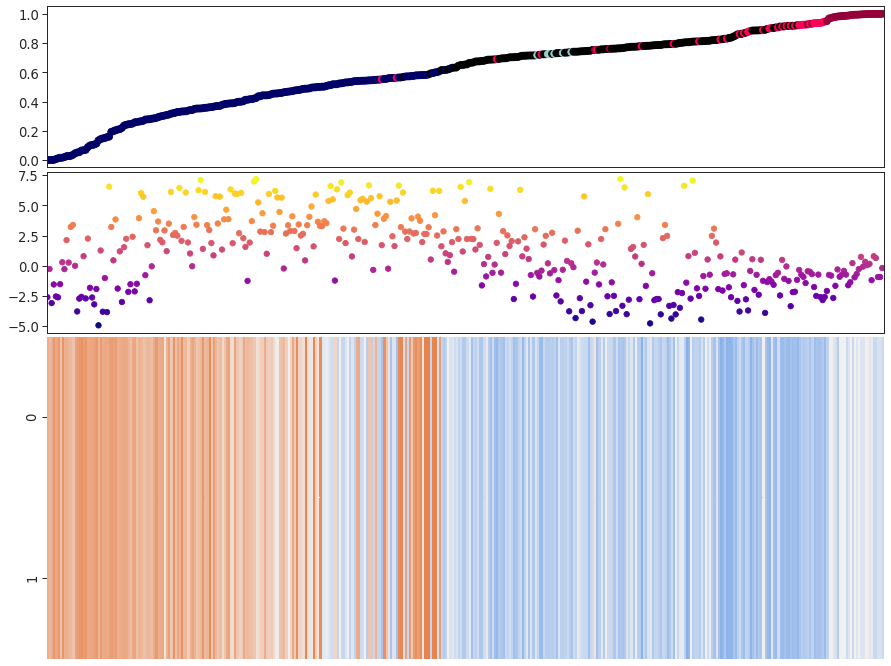

In [54]:
fig,ax = plt.subplots(3,1,figsize=(15,12),gridspec_kw={'height_ratios':(1,1,2)})

nhood_order = np.argsort(pr_res.pseudotime)
nhood_colors = [celltype_colors[i] for i in DA_results_annot.index]

ax_1 = ax[0]
ax_1.set_xlim(0,nhood_exp_z.shape[0])

ax_1.scatter(range(len(nhood_order)),pr_res.pseudotime[nhood_order],s=50,
             c=np.array(nhood_colors)[nhood_order],cmap='plasma')
ax_1.set_xticks([])
#ax_1.set_ylabel("Pseudotime")

ax_ = ax[1]
ax_.set_xlim(0,nhood_exp_z.shape[0])

ax_.scatter(range(len(nhood_order)),DA_results.logFC.values[nhood_order],s=30,
            c=DA_results.logFC.values[nhood_order],cmap='plasma')
ax_.set_xticks([])

mat = [nhood_exp_z[np.intersect1d(geneset,list(sc.data_normalized))].mean(1),
       nhood_exp_z[np.intersect1d(geneset,list(sc.data_normalized))].mean(1)]
mat = np.vstack(mat)
mat = (mat.T-mat.mean(1))/mat.std(1)

sns.heatmap(mat.T[:,nhood_order],vmin=-2,vmax=2,
           cmap=sns.diverging_palette(250, 30, l=65, as_cmap=True),ax=ax[2],cbar=False)
ax[2].set_xticks([])

plt.subplots_adjust(wspace=0, hspace=.02)

## Immune Modules

In [55]:
cliques_epi = pickle.load(open(working_dir+"analysis_outputs/crosstalk/cliques_iterative_filtered_Epi.pickle",'rb'))

In [56]:
mat4 = []
for i,cl in enumerate(cliques_epi):
    cl_ = np.intersect1d(cl,list(nhood_exp_z))
    mat4.append(nhood_exp_z_heatmap[cl_].mean(1))
mat4 = np.vstack(mat4)

rgb_cols = np.array([[0,1,1],
[.7,0,0],
[.6,.6,0],
[0,0,1],
[1,0,1],
[0,.6,0],])

colors_all = np.vstack(mat4)[[0,1,2,4,5,6],:]
colors_all = ((colors_all.T-colors_all.min(1))/(colors_all.max(1)-colors_all.min(1))).T

#colors_all.T.dot(rgb_cols)
Psuedo_colors = colors_all.T.dot(rgb_cols)
Psuedo_colors[Psuedo_colors > 1] = 1
Psuedo_colors[Psuedo_colors < 0] = 0

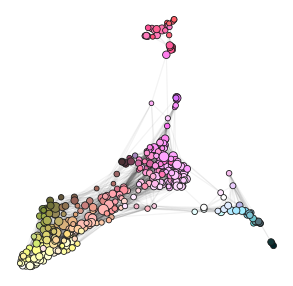

In [57]:
fig,ax=plt.subplots(figsize=(5,5))
plot_G2(nh_tsne_df,
           nhood_graph,
           alpha_G=0.05,ax=ax,
           color_G='k',
           s=nh_size*1,cmap='plasma',
           t=Psuedo_colors,colorbar=False)
plt.savefig(working_dir+"final_figures/Figure6/shIL33MILO-FDL_ModuleColors.pdf",bbox_inches='tight')
plt.savefig(working_dir+"final_figures/Figure6/shIL33MILO-FDL_ModuleColors.png",bbox_inches='tight')

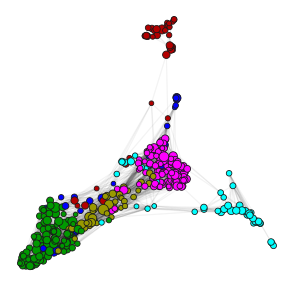

In [58]:
fig,ax=plt.subplots(figsize=(5,5))
plot_G2(nh_tsne_df,
           nhood_graph,
           alpha_G=0.05,ax=ax,
           color_G='k',
           s=nh_size*1,cmap='plasma',
           t=rgb_cols[np.argmax(mat4[[0,1,2,4,5,6],:],axis=0),:],colorbar=False)
plt.savefig(working_dir+"final_figures/Figure6/shIL33MILO-FDL_ModuleAssignments.pdf",bbox_inches='tight')
plt.savefig(working_dir+"final_figures/Figure6/shIL33MILO-FDL_ModuleAssignments.png",bbox_inches='tight')

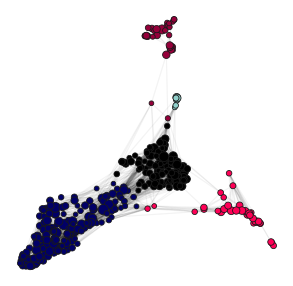

In [59]:
fig,ax=plt.subplots(figsize=(5,5))
plot_G2(nh_tsne_df,
           nhood_graph,
           alpha_G=0.05,ax=ax,
           color_G='k',
           s=nh_size*1,cmap='plasma',
           t=nhood_colors,colorbar=False)
plt.savefig(working_dir+"final_figures/Figure6/shIL33MILO-FDL_Clusters.png",bbox_inches='tight')

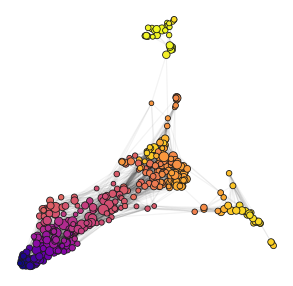

In [60]:
fig,ax=plt.subplots(figsize=(5,5))
plot_G2(nh_tsne_df,
           nhood_graph,
           alpha_G=0.05,ax=ax,
           color_G='k',
           s=nh_size*1,cmap='plasma',
           t=pr_res.pseudotime,colorbar=False)
plt.savefig(working_dir+"final_figures/Figure6/shIL33MILO-FDL_Pseudotime.png",bbox_inches='tight')

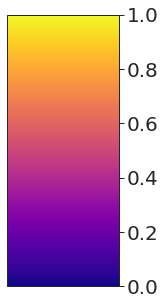

In [61]:
fig,ax = plt.subplots(figsize=(2,5))

#adding colorbar
cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=np.min(pr_res.pseudotime), vmax=np.max(pr_res.pseudotime))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm,ax)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(20)
    
plt.savefig(working_dir+"final_figures/Figure6/shIL33MILO-FDL_Pseudotime_colorbar.pdf",bbox_inches='tight')

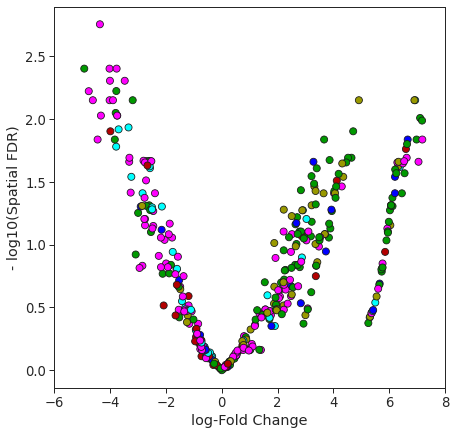

In [62]:
fig,ax=plt.subplots(figsize=(7,7))


#inspect fold change and FDR in a volcano plot
ax.scatter(DA_results.logFC, -np.log10(DA_results.SpatialFDR),s=50,
           c=rgb_cols[np.argmax(mat4[[0,1,2,4,5,6],:],axis=0),:],edgecolor='k');
ax.set_xlim(-6,8)

plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.savefig(working_dir+"final_figures/Figure6/shIL33MILO-VolcanoPlot.pdf",bbox_inches='tight')
plt.savefig(working_dir+"final_figures/Figure6/shIL33MILO-VolcanoPlot.png",bbox_inches='tight')

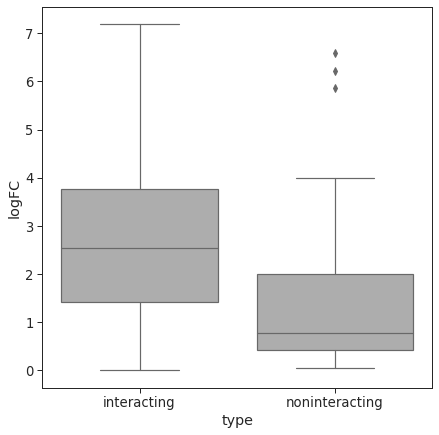

In [63]:
fig,ax=plt.subplots(figsize=(7,7))


mod_assignment = np.argmax(mat4,axis=0)
status_assignment = [status_dict[i] for i in mod_assignment]

tmp_df = pd.DataFrame((status_assignment,np.abs(DA_results['logFC'].values)),index=['type','logFC']).T
tmp_df.logFC = tmp_df.logFC.values.astype(np.float32)
sns.boxplot(data=tmp_df,x='type',y='logFC',order=['interacting','noninteracting'],
            palette=['#ADADAD','#ADADAD'])

plt.savefig(working_dir+"final_figures/Figure6/shIL33MILO-InteractionBoxplot.pdf",bbox_inches='tight')

In [64]:
nonint = tmp_df.set_index("type").loc['noninteracting']['logFC'].values
inter = tmp_df.set_index("type").loc['interacting']['logFC'].values

tstat = scipy.stats.ttest_ind(a=nonint,b=inter)[0] #need to update to two sided

In [65]:
tstat

-5.251044418650925

In [66]:
from scipy.stats import t
t.cdf(x=tstat,df=nonint.shape[0]+inter.shape[0]-2)

1.244253832495265e-07

In [67]:
mod_order = [6,2, 5, 0,4, 1]

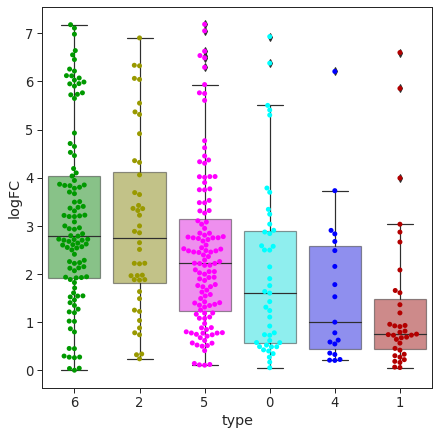

In [68]:
fig,ax=plt.subplots(figsize=(7,7))

rgb_cols_all = np.array([[0,1,1],
[.7,0,0],
[.6,.6,0],
[1,1,1],                         
[0,0,1],
[1,0,1],
[0,.6,0],])

rgb_cols_all2 = np.array([[0,1,1],
[.7,0,0],
[.6,.6,0],
[0,0,0],                         
[0,0,1],
[1,0,1],
[0,.6,0],])

tmp_df = pd.DataFrame((mod_assignment,np.abs(DA_results['logFC'].values)),index=['type','logFC']).T
tmp_df.logFC = tmp_df.logFC.values.astype(np.float32)
sns.boxplot(data=tmp_df,x='type',y='logFC',palette=rgb_cols_all[mod_order,:],order=mod_order,boxprops=dict(alpha=.5))

sns.swarmplot(data=tmp_df,x='type',y='logFC',palette=rgb_cols_all2[mod_order,:],order=mod_order)

plt.savefig(working_dir+"final_figures/Figure6/shIL33MILO-ModuleBoxplot.pdf",bbox_inches='tight')

In [69]:
status_dict

{4: 'noninteracting',
 6: 'interacting',
 0: 'interacting',
 1: 'noninteracting',
 2: 'interacting',
 3: 'interacting',
 5: 'interacting'}

# Combined Heatmap

In [70]:
mat0 = nhood_exp_z_heatmap[['NES']].iloc[nhood_order].T

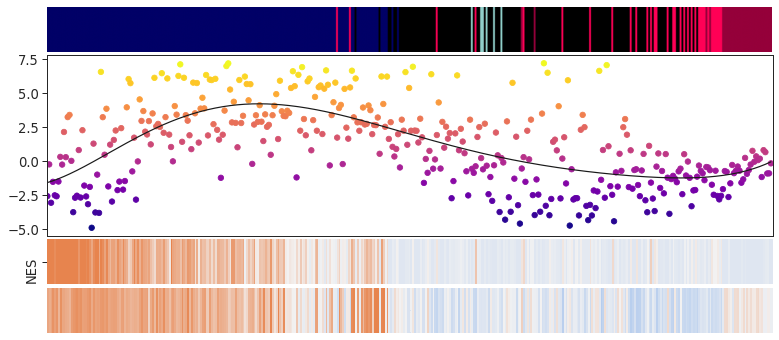

In [73]:
fig,ax = plt.subplots(4,1,
                      figsize=(13,6),gridspec_kw={'height_ratios':(1,4,mat0.shape[0],mat0.shape[0])})

regressionLineOrder = 6
regressionLine = np.polyfit(np.arange(len(nhood_order)),DA_results.logFC.values[nhood_order], regressionLineOrder)
p = np.poly1d(regressionLine)

nhood_order = np.argsort(pr_res.pseudotime)
x_range = np.arange(len(nhood_order))

ax_1 = ax[0]
ax_1.set_xlim(0,nhood_exp_z.shape[0])

col_rgb_colors = np.asarray([matplotlib.colors.to_rgb(i) for i in np.array(nhood_colors)[nhood_order]])
ax[0].imshow(np.tile(col_rgb_colors[None, :, :], [1000, 1, 1]),aspect="auto")
ax[0].set_axis_off()

ax_ = ax[1]
ax_.set_xlim(0,nhood_exp_z.shape[0])

ax_.scatter(range(len(nhood_order)),DA_results.logFC.values[nhood_order],s=30,
            c=DA_results.logFC.values[nhood_order],cmap='plasma')
ax_.plot(x_range, p(x_range),c='k')
ax_.set_xticks([])

#heatmap 1
sns.heatmap(mat0,
           vmin=-3,vmax=2,
           cmap=sns.diverging_palette(250, 30, l=65, as_cmap=True),ax=ax[2],cbar=False)
ax[2].set_xticks([])

#heatmap 2
sns.heatmap(mat.T[:,nhood_order],vmin=-3,vmax=2,yticklabels="",
           cmap=sns.diverging_palette(250, 30, l=65, as_cmap=True),ax=ax[3],cbar=False)
ax[3].set_xticks([])


plt.subplots_adjust(wspace=0, hspace=.04)

plt.savefig(working_dir+"final_figures/Figure6/shIL33MILO-CombinedHeatmap.png",bbox_inches='tight')

In [74]:
import matplotlib as mpl

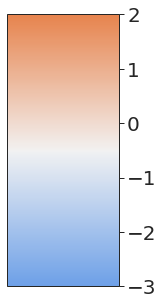

In [75]:
fig,ax = plt.subplots(figsize=(2,5))

#adding colorbar
cmap = sns.diverging_palette(250, 30, l=65, as_cmap=True)
norm = mpl.colors.Normalize(vmin=-3, vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm,ax)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(20)
    
plt.savefig(working_dir+"final_figures/Figure6/shIL33MILO-CombinedHeatmap_scale.pdf",bbox_inches='tight')

In [76]:
DA_results_annot.to_csv(working_dir+"final_outputs/Figure6/DAResultsAnnot.csv",index=True,header=True)